In [1]:
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import Functions that we will be using

In [3]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_day_df(df_main, day_to_use=None):

    # Create new DataFrame for country-level analysis
    df_today = df_main.copy()
    
    # Aggregates suming the values for different states
    df_today = df_today.groupby(level = ['country', 'date']).sum().sort_index()

    # Drop unused columns
    df_today = df_today.drop(columns=['lat', 'long'])
    
    # Keep a signle date in the dataframe
    if day_to_use is None:
        day_to_use = df_today.index.get_level_values('date').max()
    

    idx = pd.IndexSlice
    df_today = df_today.loc[idx[:,day_to_use], :]    
    
    return df_today

In [4]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_country_df(df_main, country=None):
    
    # Create new DataFrame for single coubtry analysis
    df_country = df_main.copy()
    
    # Aggregates suming the values for different states
    df_country = df_country.groupby(level = ['country', 'date']).sum().sort_index()
    
    # Drop unused columns
    df_country = df_country.drop(columns=['lat', 'long'])
    
    # If a country was not provided retur None
    if country is None:
        return None
    
    # Keep a signle country in the dataframe and remove first two dates
    
    # Because of the .diff() operator, the faetures 'new_infections' and 'new_infections_increase'
    # have values of the previous country in the first two dates available for each country.
    first_date_to_use = df_country.index.get_level_values('date').min() + pd.Timedelta(days=2)
    
    idx = pd.IndexSlice
    df_country = df_country.loc[idx[country, first_date_to_use:], :] 
    
    return df_country


In [5]:
# Prints Last Day View plots 

def plot_today_figures(df_today, var_to_plot, pop=None, num_countries=10, min_pop = 1):
    
    df_plot = df_today[[var_to_plot]].copy()
    
    # save the last date and drop date index
    last_date_str = df_plot.index.get_level_values('date').max().strftime("%d-%b-%Y") 
    df_plot = df_plot.reset_index(level='date', drop=True)
    
    if pop is not None:
        
        # validade population DataFrame
        assert isinstance(pop, pd.DataFrame)
        assert pop.index.name == 'country'
        assert 'million_people' in pop.columns
        
        # merge with COVID DataFrame
        df_plot = pd.merge(df_plot, pop, how='inner', on='country', validate='one_to_one')
        
        # Create variable to plot formatted with correct units
        df_plot['plot_this'] = df_plot[var_to_plot] / df_plot['million_people']
        
        # Drop countries with less than min_pop population
        df_plot = df_plot.loc[df_plot.million_people > min_pop,:]
        
    else:
        df_plot['plot_this'] = df_plot[var_to_plot]

    
    
    # select top countries
    top_list = df_plot.loc[:, 'plot_this'].sort_values(ascending=False).iloc[:num_countries].index.tolist()
    
    if "portugal" not in top_list:
        top_list.append("portugal")
    
    # Format plot title
    plot_title_str = '{} on {}'.format(var_to_plot, last_date_str).replace('_', ' ').capitalize()
    if 'increase' in plot_title_str:
        plot_title_str += ' from previous day value' 
    
    # Format ylabel
    if pop is not None:
        y_lab = 'per million people'
    else:
        y_lab = 'total'
    
    # Format plot file name
    file_name_str = var_to_plot + '_' + y_lab.replace(' ', '_')
    
    # Plot
    df_plot.loc[top_list, ['plot_this']].plot.bar(figsize=(8,4))
    
    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel('[{}]'.format(y_lab))
    plt.xticks(rotation=25)
    
    plt.savefig(os.path.join('plots', file_name_str));

    
    return df_plot, top_list

In [6]:
def plot_country_figures(df_country, 
                         min_num_cases = 100,
                         var_to_plot='new_infections', 
                         log=True, 
                         pct_change=False, 
                         rolling=7):
    
    df_plot = df_country.copy()
    
    # Record the date when the number of comfirmed cases exceeds the minimum number of cases (min_num_cases)
    first_date = df_plot.loc[ df_plot.total_infections > min_num_cases, :].index.get_level_values('date')[0]
    
    # Save country name and remove it from the DataFrame index
    country_name = df_plot.index.get_level_values('country')[0]
    
    if var_to_plot is None:
        print("plot_country_figures(): no variable was defined")
        return
    
    # Save a new time series with the variable to plot
    df_plot = df_plot.reset_index(level='country', drop=True)
    ts = df_plot[var_to_plot]
    
    # We assume that when the variable takes the value zero it means missing
    ts = ts.replace(to_replace=0, value=np.nan)
    
    # Format plot title and y axis label
    plot_title_str = var_to_plot 
    y_lab = ""
    
    if pct_change == True:
        ts = ts.pct_change().multiply(100)
        
        # we assum more than 500% increase is an error in reporting
        ts[ts > 500] = np.nan
        
        plot_title_str += " growth rate"
        y_lab = "[%]"
        # if pct_change is True, then it makes no sense to use log scale
        log = False
        
        if rolling > 1:
            ts = ts.rolling(rolling, min_periods=1).mean()

            plot_title_str += " ({} days moving average)".format(rolling)
    
    
    plot_title_str = plot_title_str.replace('_', ' ').capitalize()
    plot_title_str += " in {}".format(country_name.upper())
    
    # Format ylabel
    if log == True:
        y_lab = '[log. scale]'  
    
    
    ts[first_date:].plot(figsize=(8,4), marker='D', markersize=4, logy=log)

    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel(y_lab)
    plt.show();
    
    return ts

In [7]:
# read world population DataFrame
df_population = pd.read_pickle('./data/df_population.pkl')

In [8]:
# read the complete COVID DataFrame
df_main = pd.read_pickle('./data/df_main.pkl')

In [9]:
idx = pd.IndexSlice

In [10]:
# Record last available date
last_date = df_main.index.get_level_values('date').max()

# Last Day View

In [11]:
# Build today country-level DataFrame
df_today = build_single_day_df(df_main)

In [12]:
df_main.head()

lat  long  total_infections  new_infections  \
country     state date                                                       
afghanistan       2020-01-22  33.0  65.0               0.0             NaN   
                  2020-01-23  33.0  65.0               0.0             0.0   
                  2020-01-24  33.0  65.0               0.0             0.0   
                  2020-01-25  33.0  65.0               0.0             0.0   
                  2020-01-26  33.0  65.0               0.0             0.0   

                              new_infections_increase  total_deaths  \
country     state date                                                
afghanistan       2020-01-22                      NaN           0.0   
                  2020-01-23                      NaN           0.0   
                  2020-01-24                      0.0           0.0   
                  2020-01-25                      0.0           0.0   
                  2020-01-26                      0.0           0.0   

                              new_deaths  
country     state date                    
afghanistan       2020-01-22         NaN  
                  2020-01-23         0.0  
                  2020-01-24         0.0  
                  2020-01-25         0.0  
                  2020-01-26         0.0

In [14]:
df_main2 = df_main.groupby(level = ['country', 'date']).sum().sort_index()

In [15]:
df_main2.head()

lat  long  total_infections  new_infections  \
country     date                                                       
afghanistan 2020-01-22  33.0  65.0               0.0             0.0   
            2020-01-23  33.0  65.0               0.0             0.0   
            2020-01-24  33.0  65.0               0.0             0.0   
            2020-01-25  33.0  65.0               0.0             0.0   
            2020-01-26  33.0  65.0               0.0             0.0   

                        new_infections_increase  total_deaths  new_deaths  
country     date                                                           
afghanistan 2020-01-22                      0.0           0.0         0.0  
            2020-01-23                      0.0           0.0         0.0  
            2020-01-24                      0.0           0.0         0.0  
            2020-01-25                      0.0           0.0         0.0  
            2020-01-26                      0.0           0.0         0.0

In [16]:
last_date = df_main2.index.get_level_values('date').max()# - pd.Timedelta(days=2)
last_date

Timestamp('2020-03-30 00:00:00')

In [68]:
#var_to_use = "new_infections"
var_to_use = "new_deaths"
num_countries = 10
last_date = df_main2.index.get_level_values('date').max()
start_date = last_date - pd.Timedelta(days=15)
countries_list = df_main2.loc[idx[:, start_date:last_date], var_to_use].groupby('country').sum().sort_values(ascending=False)[:num_countries].index.tolist()

In [69]:
countries_list

['italy',
 'spain',
 'france',
 'us',
 'iran',
 'united kingdom',
 'netherlands',
 'germany',
 'belgium',
 'switzerland']

In [70]:
df_main2.loc[idx[countries_list, start_date:last_date], var_to_use]

country         date      
belgium         2020-03-15      0.0
                2020-03-16      1.0
                2020-03-17      5.0
                2020-03-18      4.0
                2020-03-19      7.0
                2020-03-20     16.0
                2020-03-21     30.0
                2020-03-22      8.0
                2020-03-23     13.0
                2020-03-24     34.0
                2020-03-25     56.0
                2020-03-26     42.0
                2020-03-27     69.0
                2020-03-28     64.0
                2020-03-29     78.0
                2020-03-30     82.0
france          2020-03-15      0.0
                2020-03-16     58.0
                2020-03-17      0.0
                2020-03-18      0.0
                2020-03-19     95.0
                2020-03-20    207.0
                2020-03-21    112.0
                2020-03-22    113.0
                2020-03-23    186.0
                2020-03-24    240.0
                2020-03-25    231.0
 

In [71]:
df_main2.loc[idx[countries_list, start_date:last_date], var_to_use].unstack(level='country')[countries_list]

country,italy,spain,france,us,iran,united kingdom,netherlands,germany,belgium,switzerland
date,,,,,,,,,,
2020-03-15,368.0,94.0,0.0,9.0,113.0,0.0,8.0,2.0,0.0,1.0
2020-03-16,349.0,53.0,58.0,22.0,129.0,35.0,4.0,6.0,1.0,0.0
2020-03-17,345.0,191.0,0.0,23.0,135.0,0.0,19.0,7.0,5.0,13.0
2020-03-18,475.0,90.0,0.0,10.0,147.0,16.0,15.0,4.0,4.0,1.0
2020-03-19,427.0,207.0,95.0,82.0,149.0,66.0,19.0,16.0,7.0,13.0
2020-03-20,627.0,213.0,207.0,44.0,149.0,40.0,30.0,23.0,16.0,13.0
2020-03-21,793.0,332.0,112.0,63.0,123.0,56.0,30.0,17.0,30.0,21.0
2020-03-22,651.0,397.0,113.0,110.0,129.0,48.0,43.0,10.0,8.0,23.0
2020-03-23,601.0,539.0,186.0,140.0,127.0,54.0,34.0,29.0,13.0,22.0


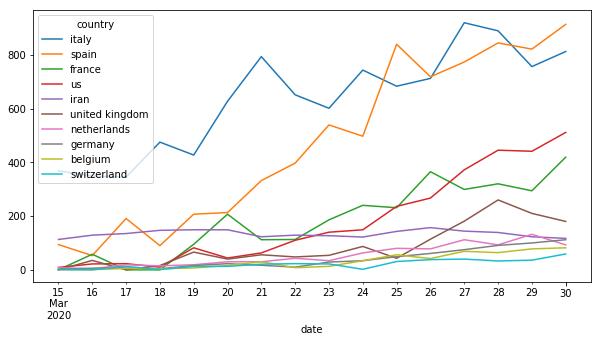

In [74]:
df_main2.loc[idx[countries_list, start_date:last_date], var_to_use].unstack(level='country')[countries_list].plot(figsize=(10,5))

# The SIR model  

<img src="./media/Typical-SIR-model-solution-showing-progression-of-population-disease-states-for.PNG" style="float:left; width:500px"/>  

<br clear="all">

$\dfrac{dS}{dt} = - \dfrac{\beta I S}{N}$  

$\dfrac{dI}{dt} = \dfrac{\beta I S}{N} - \gamma I$  

$\dfrac{dR}{dt} = \gamma I$  

with $R_0 = \dfrac{\beta}{\gamma}$.  

### In the initial stages of propagation the nº of infected is exponential with rate $R_0$ (confirm)  

### Explain why the appearence of more sources does not change the evolution rate  

### How to estimate $R_0$?  
* The effect of testing (with know only a percentage of infeted)
* The effect of social distancing measures

### Estimate the impact of lockdown on $R_0$

In [13]:
# Keep last available values
last_date = df_today.index.get_level_values('date').max()

idx = pd.IndexSlice
df_today = df_today.loc[idx[:,last_date], :]
df_today = 

SyntaxError: invalid syntax (<ipython-input-13-e4b485753724>, line 6)

In [ ]:
df_today[[:,:],:]

In [ ]:
last_date - pd.Timedelta('10 D')

In [ ]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

### Choose variable

In [ ]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [ ]:
# choose data format: total or new
data_format = "new"

---

In [ ]:
# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [ ]:
# If analysis of new cases compute difference from previous day
if data_format == "new":
    df_today.loc[:,['confirmed', 'recovered', 'deaths']] = df_today.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

In [ ]:
# select last available date
last_date = df.date.drop_duplicates().sort_values().iloc[-1]
last_date

In [ ]:
df_today = df_today.loc[df_today.date == last_date,: ].reset_index(drop=True)
df_today = df_today.loc[:, ['date', 'country', 'confirmed', 'recovered', 'deaths']]

In [ ]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

In [ ]:
# select top-level countries plus portugal
top_number = 10
top_list = cs_countries.sort_values(ascending=False).iloc[:top_number].index.tolist()

if "portugal" not in top_list:
    top_list.append("portugal")

In [ ]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [ ]:
df_today

In [ ]:
pd.merge(df_today, df_population, how='left', on='country', validate='many_to_one')

In [ ]:
pd.merge(df_clean, df_hospitais_codes, how='left', on='clean_name', validate='many_to_one')

---

# Single country analysis - time series

### Choose country, state

In [ ]:
# choose country
country = "spain"

# choose state
state = ""

### Choose variable

In [ ]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [ ]:
# choose data format: total or new
data_format = "new"

---

In [ ]:
# Confirm aceptable values for country and state
assert country in df.country.values
assert state in df.loc[df.country==country].state.values

# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [ ]:
# same DataFrame but only for one country
df_country = df.loc[(df.country==country) & (df.state==state)].reset_index(drop = True).sort_values(by='date')

# confirm that we have only one observation per day
assert df_country.date.duplicated().sum() == 0

# set data as DataFrame index
df_country = df_country.set_index('date')

In [ ]:
# drop values before the number of comfirmed cases exceeds a minimum number of cases (min_num_cases)
min_num_cases = 1000

first_date = df_country['confirmed'].loc[df_country['confirmed'] > min_num_cases].index[0]
#first_date

In [ ]:
if data_format == "new":
    df_country.loc[:,['confirmed', 'recovered', 'deaths']] = df_country.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

### time-trend plot

In [ ]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
plt.ylabel('');

### time-trend plot (log scale)

In [ ]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4, logy=True)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - log scale'.format(data_format, variable, country, state))
plt.ylabel('');

### daily growth rate

In [ ]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change'.format(data_format, variable, country, state))
plt.ylabel('[%]');

### daily growth rate - rolling mean

In [ ]:
num_days = 7

plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).rolling(num_days, min_periods=num_days-2).mean().plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change {} days rolling-mean'.format(data_format, variable, country, state, num_days))
#plt.title('Daily pct. change of {} cases for {} {} - {} days rolling-mean'.format(variable, country, state, num_days))
plt.ylabel('[%]');


---

### Nº of days to double cases

In [ ]:
daily_growth = 0.05

In [ ]:
num_days_to_double = (np.log(2))/(np.log(1+daily_growth))
num_days_to_double

In [ ]:
x =np.arange(0,30,1)
y = 1000*(1+0.1)**x

In [ ]:
plt.plot(x, y);

In [ ]:
ys = pd.Series(y)

In [ ]:
ys.pct_change()

In [ ]:
ys.diff().pct_change()

In [ ]:
s.plot()

In [ ]:
s.pct_change().plot()

In [ ]:
s.pct_change().rolling(7).mean().plot()

In [ ]:
df.loc[(df.country=="China") & (df.state=="Hubei"),:].confirmed.plot()